<a href="https://colab.research.google.com/github/smwalter96/PUS2020_MWalter/blob/master/HW6/HW6_Autocorrelation_MatthewWalter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Start from your HW5 (or from the solution posted)

The HW5 solution follows. Some of the tasks to are done differently than I would have if I had only the HW5 tasks to do. Those things are outlined below and they are generally in cells of code that need to be finished. The HW6 tasks proper start below ehre it says "**This is where HW2 starts**"

You will need to rerun it and make dure that 
- there are no nan values. Since a lot of the analysis you do relies on population density this will have to be done by **removing areas of 0 population** 
- after you remove precints fix the index by calling ```df_.reset_index(inplace=True)``` on your dataframe so that it does not have missing value. if it did you would be in trouble after creating the weight: you would get a missing index value (I got it for index 274) and also you might have troubles when fitting a line to the Moran's I
- make sure you convert the dataframe to feet (epsg=2263) and work your spatial analysis in feet (there is one point in which I will give you the coordinates of a specific locatoin in lat and lon: you need to either convert those in feet or reconvert temporarily the dataframe to lat-lon to do that part of the analysis)
- make sure you select a single race! the vanilla analysis we did in HW5 could work with summing all the races, but if we want to really look at voters turout, and especially voter turnout by political party and analyze blue and red votes separately, we need to make sure we do not doublecount. I chose the U.S. Senate race. If this were a real project you would need to check if choosing another rate changes your result.

NOTE: I care mostly about the interpretation of the figures in this notebook more than ever! if you cannot get a piece of code to reproduce the figure ask me. I do want you to try (so I want you to ask for it on a step by step basis), but I am happy to show you the solution. I really care about the considerations and interpretation tho!


In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import scipy as sp
import pylab as plt
import shapely

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [ ]:
!pip install geopandas

In [ ]:
!pip install -U --no-deps mapclassify git+git://github.com/geopandas/geopandas.git@master


  Cloning git://github.com/geopandas/geopandas.git (to revision master) to /tmp/pip-req-build-6ndakgvs
  Running command git clone -q git://github.com/geopandas/geopandas.git /tmp/pip-req-build-6ndakgvs
  Created wheel for geopandas: filename=geopandas-0.8.0+53.g7044aa4-py2.py3-none-any.whl size=969259 sha256=f00b7b4a087c8f5cefdceb8ef646d283550eb9f0f0380c5c9a89dc7359db4734
  Stored in directory: /tmp/pip-ephem-wheel-cache-rwt_us6j/wheels/1e/57/dc/7a5ea8503aefb23576c42181adfca7fc173fde5b71900660bc
Successfully built geopandas
  Found existing installation: geopandas 0.8.1
    Uninstalling geopandas-0.8.1:
      Successfully uninstalled geopandas-0.8.1


In [ ]:
!apt install libspatialindex-c4v5
!pip install pysal

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libspatialindex4v5
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex4v5
0 upgraded, 2 newly installed, 0 to remove and 6 not upgraded.
Need to get 270 kB of archives.
After this operation, 1,107 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-c4v5 amd64 1.8.5-5 [51.7 kB]
Fetched 270 kB in 1s (410 kB/s)
Selecting previously unselected package libspatialindex4v5:amd64.
(Reading database ... 144617 files and directories currently installed.)
Preparing to unpack .../libspatialindex4v5_1.8.5-5_amd64.deb ...
Unpacking libspatialindex4v5:amd64 (1.8.5-5) ...
Selecting previously unselected package libspatialindex-c4v5:amd64.
Preparing to un

In [ ]:
import geopandas as gpd

In [ ]:
import pysal as ps

Use the delaware opendata to extract the voting precincts geometries

https://opendata.firstmap.delaware.gov/datasets/delaware-election-boundaries

USe the election data from the turnout project to get the precinct turnout

https://raw.githubusercontent.com/openelections/openelections-data-de/master/2018/20181106__de__general__precinct.csv

# read in data

In [ ]:
vote = pd.read_csv('https://raw.githubusercontent.com/openelections/openelections-data-de/master/2018/20181106__de__general__precinct.csv')
vote = vote.loc[vote['office'] == 'U.S. Senate']
vote

,county,election_district,office,district,party,candidate,election_day,absentee,votes
0,New Castle,01-01,U.S. Senate,NaN,DEMOCRATIC,Carper T,552,29,581
1,New Castle,01-01,U.S. Senate,NaN,REPUBLICAN,Arlett R,50,1,51
2,New Castle,01-01,U.S. Senate,NaN,GREEN,Theodoropo,5,0,5
3,New Castle,01-01,U.S. Senate,NaN,LIBERTARIN,Frost N,4,2,6
4,New Castle,02-01,U.S. Senate,NaN,DEMOCRATIC,Carper T,903,34,937
...,...,...,...,...,...,...,...,...,...
1743,Sussex,16-41,U.S. Senate,NaN,LIBERTARIN,Frost N,0,0,0
1744,Sussex,Total,U.S. Senate,NaN,DEMOCRATIC,Carper T,205830,11555,217385
1745,Sussex,Total,U.S. Senate,NaN,REPUBLICAN,Arlett R,130331,6796,137127
1746,Sussex,Total,U.S. Senate,NaN,GREEN,Theodoropo,4007,163,4170


## read in electoral precinct geojson file in geopandas (directly from the URL)

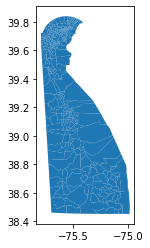

In [ ]:
# leave
de_elecp = gpd.read_file("https://opendata.arcgis.com/datasets/91c1f132c7d34885983c56b47dc675fd_0.geojson")
de_elecp.plot();

In [ ]:
# leave
de_elecp.head()

,OBJECTID,ID,EDRD_2012,POPULATION,DISTRICT,EGIS_OWNERElection_ED_RD_2012AREA,geometry
0,1,20,01-21,1171,21,None,"POLYGON ((-75.67816 39.74598, -75.67807 39.746..."
1,2,21,01-22,1755,22,None,"POLYGON ((-75.72394 39.76115, -75.72393 39.760..."
2,3,22,01-23,1947,23,None,"POLYGON ((-75.73601 39.68660, -75.73603 39.686..."
3,4,23,01-24,2828,24,None,"POLYGON ((-75.69655 39.66154, -75.69666 39.661..."
4,5,24,01-25,7734,25,None,"POLYGON ((-75.75158 39.65865, -75.75109 39.658..."


In [ ]:
# leave
de_elecp.describe()

,OBJECTID,ID,POPULATION
count,430.000000,430.000000,430.000000
mean,215.500000,216.500000,2088.218605
std,124.274562,124.274562,998.347223
min,1.000000,2.000000,0.000000
25%,108.250000,109.250000,1484.750000
50%,215.500000,216.500000,2141.500000
75%,322.750000,323.750000,2659.750000
max,430.000000,431.000000,7734.000000


## read in turnout data - keep only election district, and votes


In [ ]:
# leave
# turnout = pd.read.....
turnout = vote[['party', 'election_district', 'votes']]
turnout

,party,election_district,votes
0,DEMOCRATIC,01-01,581
1,REPUBLICAN,01-01,51
2,GREEN,01-01,5
3,LIBERTARIN,01-01,6
4,DEMOCRATIC,02-01,937
...,...,...,...
1743,LIBERTARIN,16-41,0
1744,DEMOCRATIC,Total,217385
1745,REPUBLICAN,Total,137127
1746,GREEN,Total,4170


## group by election district and get the total number of data for that district

there are multiple entries for each geometry because there entries indicate the votes per candidate.


In [ ]:
# leave
turnout.groupby(["election_district", "party"]).sum()[["votes"]]

votes
election_district party             
01-01             DEMOCRATIC     581
                  GREEN            5
                  LIBERTARIN       6
                  REPUBLICAN      51
01-02             DEMOCRATIC     694
...                              ...
17-02             REPUBLICAN      14
Total             DEMOCRATIC  217385
                  GREEN         4170
                  LIBERTARIN    3910
                  REPUBLICAN  137127

[1748 rows x 1 columns]

## merge the turnout data with the electoral map


In [ ]:
de_elecmap = de_elecp.merge(turnout.groupby("election_district").sum()[["votes"]], 
                            left_on="EDRD_2012", right_index=True, how="left")



In [ ]:
# leave this cell to show
no0votesindx = de_elecmap.POPULATION > 0
de_elecmap = de_elecmap[no0votesindx]
de_elecmap.reset_index(inplace=True)

In [ ]:
# leave this cell to show
# note you have 428 precincts with indices 0-427
de_elecmap

,index,OBJECTID,ID,EDRD_2012,POPULATION,DISTRICT,EGIS_OWNERElection_ED_RD_2012AREA,geometry,votes
0,0,1,20,01-21,1171,21,None,"POLYGON ((-75.67816 39.74598, -75.67807 39.746...",528.0
1,1,2,21,01-22,1755,22,None,"POLYGON ((-75.72394 39.76115, -75.72393 39.760...",1109.0
2,2,3,22,01-23,1947,23,None,"POLYGON ((-75.73601 39.68660, -75.73603 39.686...",185.0
3,3,4,23,01-24,2828,24,None,"POLYGON ((-75.69655 39.66154, -75.69666 39.661...",892.0
4,4,5,24,01-25,7734,25,None,"POLYGON ((-75.75158 39.65865, -75.75109 39.658...",682.0
...,...,...,...,...,...,...,...,...,...
423,425,426,424,08-38,2042,38,None,"POLYGON ((-75.12161 38.45119, -75.12186 38.451...",1197.0
424,426,427,425,08-40,1684,40,None,"POLYGON ((-75.43038 38.65207, -75.43017 38.651...",598.0
425,427,428,426,08-41,2785,41,None,"POLYGON ((-75.36290 38.58543, -75.36268 38.585...",531.0
426,428,429,427,09-20,414,20,None,"POLYGON ((-75.27245 38.80446, -75.27254 38.804...",247.0


## make 3 maps: a coropleth of the population by electoral precinct, votes by precinct, and people density. 

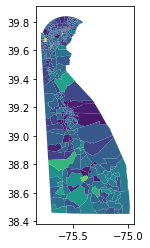

In [ ]:
# leave
# exploratory plot

de_elecmap.plot(column="POPULATION");

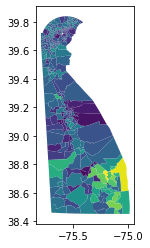

In [ ]:
# leave
# exploratory plot
de_elecmap.plot(column="votes");

In [ ]:
de_elecmap_ft =  de_elecmap.to_crs({'init': 'epsg:2263'})
de_elecmap["popdensity"] = (de_elecmap.POPULATION / de_elecmap_ft.geometry.area * 5280 * 5280)


/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


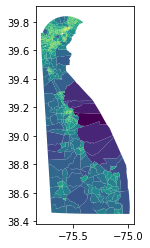

In [ ]:
# leave
de_elecmap.plot(column="popdensity", 
                norm=matplotlib.colors.LogNorm());


## look at the variables' correlation

In [ ]:
# leave
de_elecmap.corr()

,index,OBJECTID,ID,POPULATION,votes,popdensity
index,1.000000,1.000000,0.991604,0.040705,0.147145,-0.353621
OBJECTID,1.000000,1.000000,0.991604,0.040705,0.147145,-0.353621
ID,0.991604,0.991604,1.000000,0.038756,0.146066,-0.353507
POPULATION,0.040705,0.040705,0.038756,1.000000,0.647286,-0.036099
votes,0.147145,0.147145,0.146066,0.647286,1.000000,-0.242323
popdensity,-0.353621,-0.353621,-0.353507,-0.036099,-0.242323,1.000000


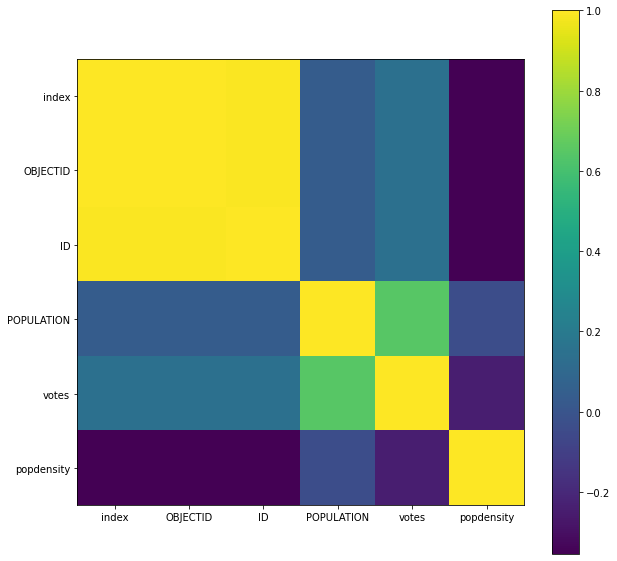

In [ ]:
# leave
# Correlation matrix - we will discuss this kind of plot soon
plt.figure(figsize=(10,10))
plt.imshow(de_elecmap.corr())
plt.xticks(range(len(de_elecmap.corr())), de_elecmap.corr().columns)
plt.yticks(range(len(de_elecmap.corr())), de_elecmap.corr().columns)
plt.colorbar();


## fit a line model to the data and a polynomial of second degree. 

# extra credit: set up the problem as a machine leraning problem by splitting the sample into training and test data and evaluating the model on both sets.


In [ ]:
# leave
import statsmodels.formula.api as smf
import statsmodels.api as sm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# leave
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [ ]:
# leave
X_train, X_test, y_train, y_test = train_test_split(de_elecmap.POPULATION.values, 
                                                    de_elecmap.votes.values, test_size=0.25, 
                                                     random_state=302)
X_train

# or I can do
np.random.seed(302)
inds = np.sort(np.random.choice(de_elecmap.index, 
                                int(de_elecmap.shape[0] * 0.75), replace=False))

In [ ]:
# remove
de_elecmap_train = de_elecmap[["votes", "POPULATION", "popdensity"]].loc[inds].dropna()
de_elecmap_test = de_elecmap[["votes", "POPULATION", "popdensity"]].loc[
  np.array([i for i in de_elecmap.index if not i in inds ])].dropna()

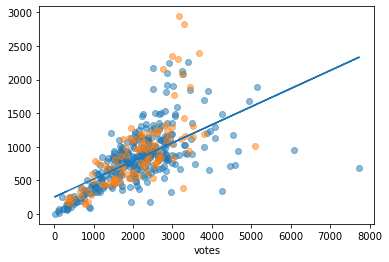

In [ ]:
# remove
# these syntaxes are equivalent
# model1 = sm.OLS(y_train, X_train).fit()
model1 = smf.ols(formula = "votes ~ POPULATION", data=de_elecmap_train).fit()
ypred = model1.predict() 
plt.scatter(de_elecmap_train.POPULATION, de_elecmap_train.votes, alpha=0.5)
plt.scatter(de_elecmap_test.POPULATION, de_elecmap_test.votes, alpha=0.5);
plt.xlabel("population")
plt.xlabel("votes")
plt.plot(de_elecmap_train.POPULATION, ypred);

In [ ]:
# remove
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  votes   R-squared:                       0.416
Model:                            OLS   Adj. R-squared:                  0.414
Method:                 Least Squares   F-statistic:                     226.8
Date:                Tue, 13 Oct 2020   Prob (F-statistic):           4.27e-39
Time:                        13:42:26   Log-Likelihood:                -2312.8
No. Observations:                 321   AIC:                             4630.
Df Residuals:                     319   BIC:                             4637.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    250.5485     41.578      6.026      0.000     168.747     332.350
POPULATION     0.2691      0.018     15.061      0.000       0.234       0.304
==============================================================================
Omnibus:                       40.869   Durbin-Watson:                   1.884
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              205.758
Skew:                           0.335   Prob(JB):                     2.09e-45
Kurtosis:                       6.865   Cond. No.                     5.31e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.31e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  votes   R-squared:                       0.530
Model:                            OLS   Adj. R-squared:                  0.527
Method:                 Least Squares   F-statistic:                     179.0
Date:                Tue, 13 Oct 2020   Prob (F-statistic):           8.22e-53
Time:                        13:42:26   Log-Likelihood:                -2278.0
No. Observations:                 321   AIC:                             4562.
Df Residuals:                     318   BIC:                             4573.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            -80.5924     53.081     -1.518      0.130    -185.027      23.842
I(POPULATION ** 2) -6.594e-05   7.51e-06     -8.782      0.000   -8.07e-05   -5.12e-05
POPULATION             0.5982      0.041     14.672      0.000       0.518       0.678
==============================================================================
Omnibus:                       55.542   Durbin-Watson:                   1.888
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              136.483
Skew:                           0.832   Prob(JB):                     2.31e-30
Kurtosis:                       5.727   Cond. No.                     2.51e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.51e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

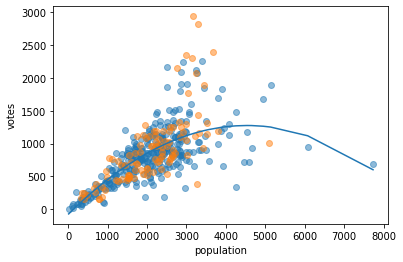

In [ ]:
# remove
model2 = smf.ols(formula = "votes ~ I(POPULATION**2) + POPULATION", data=de_elecmap_train).fit()
ypred = model2.predict(de_elecmap_train.sort_values("POPULATION")) 
plt.scatter(de_elecmap_train.POPULATION, de_elecmap_train.votes, alpha=0.5)
plt.scatter(de_elecmap_test.POPULATION, de_elecmap_test.votes, alpha=0.5);
plt.xlabel("population")
plt.ylabel("votes")
plt.plot(de_elecmap_train.sort_values("POPULATION").POPULATION, ypred);
model2.summary()

If you instead make a model based on population and population density, it is harder to visualize

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  votes   R-squared:                       0.467
Model:                            OLS   Adj. R-squared:                  0.464
Method:                 Least Squares   F-statistic:                     186.2
Date:                Tue, 13 Oct 2020   Prob (F-statistic):           8.56e-59
Time:                        13:42:26   Log-Likelihood:                -3095.2
No. Observations:                 428   AIC:                             6196.
Df Residuals:                     425   BIC:                             6209.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    284.3675     40.059      7.099      0.000     205.628     363.106
popdensity    -0.0230      0.004     -6.187      0.000      -0.030      -0.016
POPULATION     0.2962      0.016     18.042      0.000       0.264       0.328
==============================================================================
Omnibus:                       92.894   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              661.539
Skew:                           0.711   Prob(JB):                    2.23e-144
Kurtosis:                       8.922   Cond. No.                     1.35e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.35e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

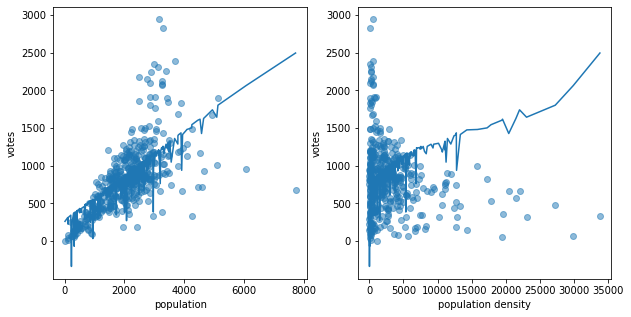

In [ ]:
# remove
model3 = smf.ols(formula = "votes ~ popdensity + POPULATION", data=de_elecmap).fit()
ypred = model3.predict(de_elecmap.sort_values("POPULATION")) 
fig = plt.figure(figsize=(10,5))

fig.add_subplot(121)
plt.scatter(de_elecmap.POPULATION, de_elecmap.votes, alpha=0.5)
plt.xlabel("population")
plt.ylabel("votes")
plt.plot(de_elecmap.sort_values("POPULATION").POPULATION, ypred);

fig.add_subplot(122)
plt.plot(de_elecmap.sort_values("popdensity").popdensity, ypred);
plt.scatter(de_elecmap.popdensity, de_elecmap.votes, alpha=0.5)
plt.xlabel("population density")
plt.ylabel("votes")
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  votes   R-squared:                       0.467
Model:                            OLS   Adj. R-squared:                  0.464
Method:                 Least Squares   F-statistic:                     186.2
Date:                Tue, 13 Oct 2020   Prob (F-statistic):           8.56e-59
Time:                        13:42:26   Log-Likelihood:                -3095.2
No. Observations:                 428   AIC:                             6196.
Df Residuals:                     425   BIC:                             6209.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    284.3675     40.059      7.099      0.000     205.628     363.106
popdensity    -0.0230      0.004     -6.187      0.000      -0.030      -0.016
POPULATION     0.2962      0.016     18.042      0.000       0.264       0.328
==============================================================================
Omnibus:                       92.894   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              661.539
Skew:                           0.711   Prob(JB):                    2.23e-144
Kurtosis:                       8.922   Cond. No.                     1.35e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.35e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

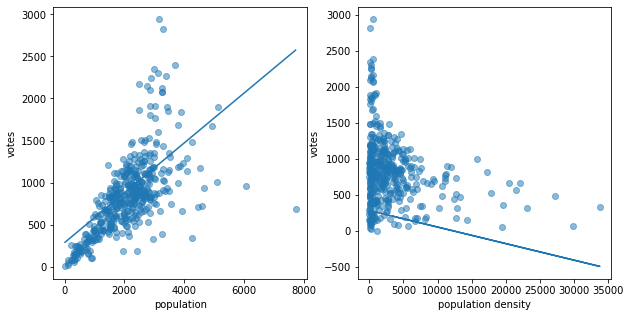

In [ ]:
# remove
fig = plt.figure(figsize=(10,5))

fig.add_subplot(121)
plt.scatter(de_elecmap.POPULATION, de_elecmap.votes, alpha=0.5)
plt.xlabel("population")
plt.ylabel("votes")
plt.plot(de_elecmap.sort_values("POPULATION").POPULATION,
         model3.params[0] + de_elecmap.sort_values("POPULATION").POPULATION * model3.params[2]);

fig.add_subplot(122)
plt.plot(de_elecmap.sort_values("POPULATION").popdensity,
         model3.params[0] + de_elecmap.sort_values("POPULATION").popdensity * model3.params[1]);
plt.scatter(de_elecmap.popdensity, de_elecmap.votes, alpha=0.5)
plt.xlabel("population density")
plt.ylabel("votes")
model3.summary()

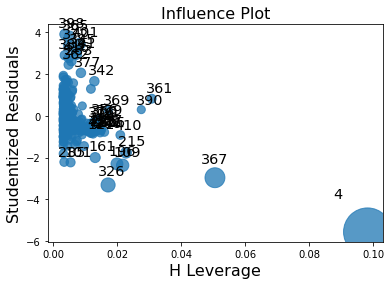

In [ ]:
# remove
sm.graphics.influence_plot(model1);


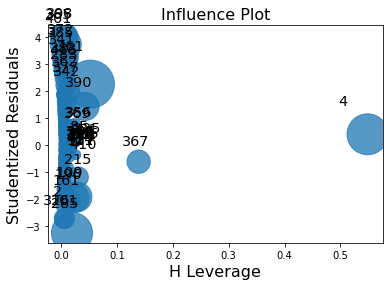

In [ ]:
sm.graphics.influence_plot(model2);


## Compare the models with the Likelihood Ratio test (follow example in class)


In [ ]:
#leave
from sklearn.metrics import r2_score 
# set alpha to 0.05
def printresult(r2, r, alpha=0.1):
  print("conveying {:d}% of the variance in the data and is".format(int(100 *r2)))
  if r < alpha:
    print("better than the first degree polynomial model (p-value {:.2f})".format(r))
  else: 
    print("too complex compared to the first degree polynomial model")

print("\nthe univariate line fit model is conveying {:d}% of the variance in the data".format(
    int(100 * r2_score(de_elecmap_test.dropna().votes, model1.predict(de_elecmap_test.dropna())))))
print("\nthe quadratic model is")
printresult(r2_score(de_elecmap_test.dropna().votes, model2.predict(de_elecmap_test.dropna())),
            model2.compare_lr_test(model1)[1])
print("\nthe multivariate model is")

printresult(r2_score(de_elecmap_test.dropna().votes, model3.predict(de_elecmap_test.dropna())),
            model3.compare_lr_test(model1)[1])



the univariate line fit model is conveying 39% of the variance in the data

the quadratic model is
conveying 44% of the variance in the data and is
better than the first degree polynomial model (p-value 0.00)

the multivariate model is
conveying 48% of the variance in the data and is
too complex compared to the first degree polynomial model


# This is where HW2 starts


## feature engineering
- create a "voterturnout" variable: the number of votes per person.

- create a "red votes" variable: the number of republican votes per person.

- create a "blue votes" variable: the number of democrat votes per person.

plot them as coropleths and comment on what you see

you want all the variable same the same geodataframe

In [ ]:
vdata = de_elecmap_ft.merge(turnout, right_on = 'election_district', left_on = 'EDRD_2012')
vdata['voterturnout'] = vdata['votes_x'] / vdata['POPULATION']
b = vdata.loc[vdata['party'] == 'DEMOCRATIC']
r = vdata.loc[vdata['party'] == 'REPUBLICAN']
b['bluevotes'] = b['votes_y'] / b['POPULATION']
r['redvotes'] = r['votes_y'] / r['POPULATION']
b = b[['EDRD_2012', 'bluevotes']]
r = r[['EDRD_2012', 'redvotes']]

vdata = pd.merge(vdata, b, on='EDRD_2012')
vdata = pd.merge(vdata, r, on='EDRD_2012')
vdata = vdata.groupby('EDRD_2012').first()
vdata = vdata.drop('party',1)
vdata.reset_index(inplace=True)
vdata

/usr/local/lib/python3.6/dist-packages/geopandas/geodataframe.py:1107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,EDRD_2012,index,OBJECTID,ID,POPULATION,DISTRICT,EGIS_OWNERElection_ED_RD_2012AREA,geometry,votes_x,election_district,votes_y,voterturnout,bluevotes,redvotes
0,01-01,5,6,2,1416,01,None,"POLYGON ((554147.102 -142629.610, 554193.665 -...",643.0,01-01,581,0.454096,0.410311,0.036017
1,01-02,6,7,3,3570,02,None,"POLYGON ((547978.129 -153315.847, 547983.095 -...",741.0,01-02,694,0.207563,0.194398,0.007843
2,01-03,7,8,4,2075,03,None,"POLYGON ((545421.985 -150041.560, 545440.395 -...",481.0,01-03,430,0.231807,0.207229,0.012530
3,01-04,8,9,5,2059,04,None,"POLYGON ((540640.585 -141818.275, 540669.265 -...",1219.0,01-04,928,0.592035,0.450704,0.126761
4,01-05,9,10,6,3027,05,None,"POLYGON ((521591.285 -194598.752, 522005.629 -...",1037.0,01-05,830,0.342583,0.274199,0.061777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423,14-04,279,280,265,382,04,None,"POLYGON ((541359.122 -146757.443, 541379.444 -...",189.0,14-04,149,0.494764,0.390052,0.075916
424,14-12,280,281,266,1154,12,None,"POLYGON ((540499.687 -115427.605, 540554.213 -...",722.0,14-12,460,0.625650,0.398614,0.214905
425,14-28,360,361,358,1027,28,None,"POLYGON ((558081.061 -357036.930, 558098.219 -...",396.0,14-28,225,0.385589,0.219085,0.163583
426,15-04,282,283,268,718,04,None,"POLYGON ((524213.977 -142894.301, 524227.388 -...",382.0,15-04,241,0.532033,0.335655,0.190808


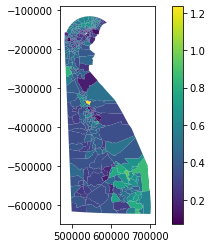

In [ ]:
# plot it all and comment...
vdata.plot(column="voterturnout", legend = True);

Figure 1: Map of voter turnout by voting precinct in the State of Delaware. Most of the northern most precincts have higher than average turnout. However, there is also one precinct in middle Delaware that has the highest turnout. The turnout in that precinct is also higher than 1, indicating that people may be travelling into the precinct to vote.

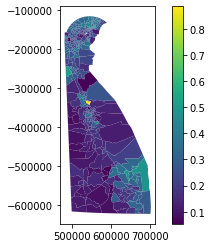

In [ ]:
vdata.plot(column="bluevotes", legend = True);

Firgure 2: Map of people registered as democrats within voting precincts in Delaware. The same county that had very high turnout also has very high democratic voters. Democratic voters are also higher in the northern part of the state.

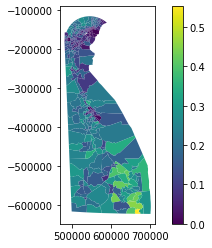

In [ ]:
vdata.plot(column="redvotes", legend = True);

Figure 3: Map of people registered as republicans within voting precincts in Delaware. There are higher amounts of republican voters in the southern most part of the state, especially near the coast line.

# create the rook and queens weights for the DE electoral map geoDF. 

you can do this by saving the df to a file and calling Rook.from_file (like in the class example) 
or you can use .from_iterable(geometry) passing the geometry series from the geoDF
(ask me if you are having a hard time...)

In [ ]:

from libpysal.weights import Queen, Rook

rook_DE = Rook.from_dataframe(vdata)
queens_DE = Queen.from_dataframe(vdata)

## what is the electoral pricincts with most neighbouring ones? is it the same for Rook and Queens weights?

note: you can use the weights object cardinalities attribute, e.g.
```rook_DE.cardinalities```
this will return a dictionary. 
To find the maximum of a dictionary you can look here 
https://www.geeksforgeeks.org/python-get-key-with-maximum-value-in-dictionary/



In [ ]:
rd = rook_DE.cardinalities
qd = queens_DE.cardinalities


RKeymax = max(rd, key= lambda x: rd[x])
QKeymax = max(qd, key= lambda x: qd[x]) 
print('The precinct with the most neighbors using the Rook method is', RKeymax, 'while the precinct with the most neighbors using the Queens method is', QKeymax, '.')
if RKeymax == QKeymax:
  print('The weights are the same for both Rook and Queens weights.')
else:
  print('The weights are not the same for both Rook and Queens weights.')

The precinct with the most neighbors using the Rook method is 4 while the precinct with the most neighbors using the Queens method is 44 .
The weights are not the same for both Rook and Queens weights.


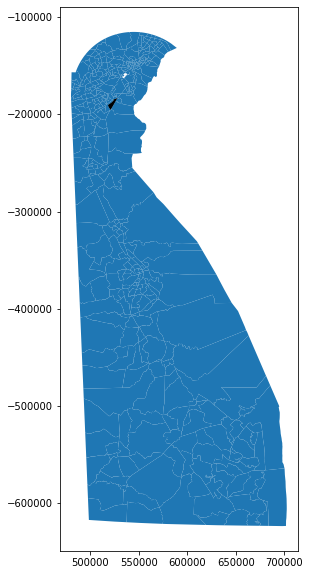

In [ ]:
ax = vdata.iloc[0:].plot(figsize = (10,10))
vdata.iloc[[4]].plot(ax=ax, color='k')

Figure 4: This map shows the precinct that has the most neighbors with Rook weights. However, there are also several precincts that tie this precinct in the amount of neighbors, which is 10.

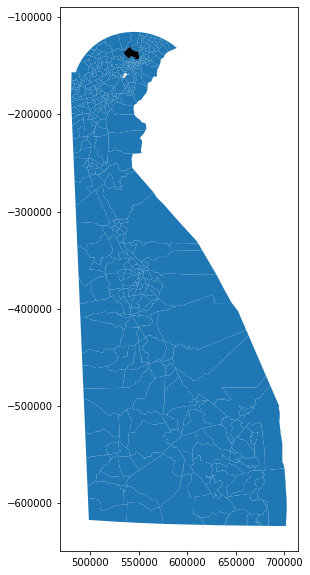

In [ ]:
ax = vdata.iloc[0:].plot(figsize = (10,10))
vdata.iloc[[44]].plot(ax=ax, color='k')

Figure 5: This map shows the precinct with the most neighbors using Queens weights. This precinct has 12 neighbors, more than any other precinct.

are there isolated electoral precincts? you can find out with the attribute of the weights "island"


In [ ]:
print('The following precincts are isolated using the Rook method:', rook_DE.islands, ', while the following precincts are isolated using the Queens method:', queens_DE.islands)

The following precincts are isolated using the Rook method: [] , while the following precincts are isolated using the Queens method: []


# challenge: wilmington center has coordinated 39.7447° N, 75.5484° W. 
find out in which precinct this location is (look at the first citibike notebook ) and find how many neighbors that precinct has in booth Rook and Queens weights


 https://automating-gis-processes.github.io/CSC18/lessons/L4/point-in-polygon.html



/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,within
100,True


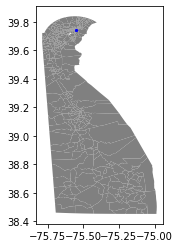

In [ ]:
from shapely.geometry import Point, Polygon

df = pd.DataFrame(
    {'City': ['Wilmington'],
     'Latitude': [39.7447],
     'Longitude': [-75.5484]})

lonlat = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))

de_elecmap_n = de_elecmap_ft.to_crs({'init': 'epsg:4326'})

fig, ax = plt.subplots()
de_elecmap_n.plot(ax=ax, facecolor='gray')
lonlat.plot(ax=ax, color='blue', markersize=5)

pip_mask = pd.DataFrame()
i=0
for n in de_elecmap_n.iterrows():
  pip_mask[i] = lonlat.within(de_elecmap_n.loc[i,'geometry'])
  i+=1
pmask = pip_mask.transpose()

pmask.columns = ['within']
pmask = pmask.loc[pmask['within'] == True]
pmask


Figure 6: The wilmington coordinate can be seen as the blue dot within one of the precincts in Delaware.

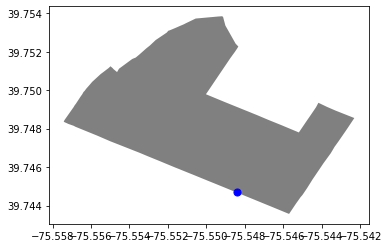

In [ ]:
fig, ax = plt.subplots()
wilm = de_elecmap_n.loc[[100],'geometry']
wilm.plot(ax=ax, facecolor='gray')
lonlat.plot(ax=ax, color='blue', markersize=50)

Figure 7: The result from the previous code block showed that the wilmington coordinate was in the 100th precinct. When the coordinate is plotted with the 100th precinct, it can be seen that they do intersect.

In [ ]:
print('The 100th precint has', rd[100], 'neighbors with rook weights, and', qd[100], 'with queens weights')

The 100th precint has 6 neighbors with rook weights, and 7 with queens weights


## make a connection plot: plot the neighborhood of the Wilmington center precincts and the Rook and Queens weights on it. 


Reproduce the diagram that shows the connectivity of the precints, the "**weights ddiagrams **" (see notebook example https://github.com/fedhere/PUS2020_FBianco/blob/master/classdemo/SpatialWeights_CitiBike.ipynb) can you see which neighbourhood assignments are different for the rook and the queens weights? can you tell why?


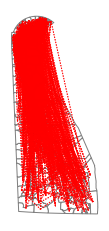

In [ ]:
ax = de_elecmap_ft.plot(edgecolor='grey', facecolor='w')
f,ax = rook_DE.plot(de_elecmap_ft, ax=ax, 
        edge_kws=dict(color='r', linestyle=':', linewidth=1),
        node_kws=dict(marker=''))
ax.set_axis_off()

Figure 8: Map of all the weight connections for Delaware voting precincts with Rooks weights. There are many connections, making it hard to visualize at this scale.

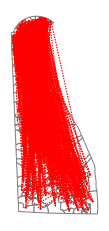

In [ ]:
ax = de_elecmap_ft.plot(edgecolor='grey', facecolor='w')
f,ax = queens_DE.plot(de_elecmap_ft, ax=ax, 
        edge_kws=dict(color='r', linestyle=':', linewidth=1),
        node_kws=dict(marker=''))
ax.set_axis_off()

Figure 9: Map of the weights diagram using Queens weights. At this scale it is difficult to determine if there are differences between the Rook weights and the Queens weights.

(-139818.275, -148818.275)

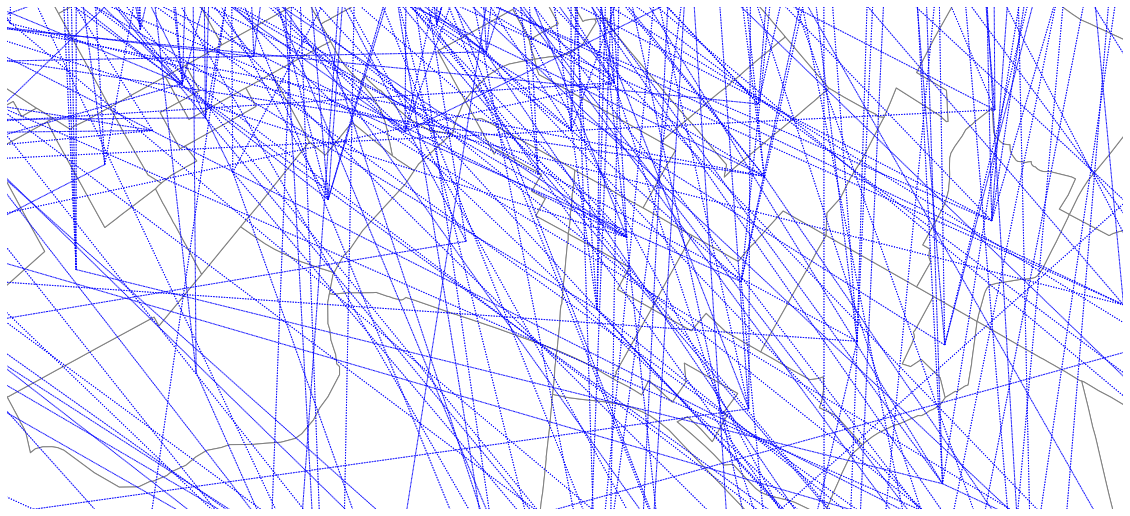

In [ ]:
ax = de_elecmap_ft[:-1].plot(edgecolor='grey', facecolor='w', figsize = (20,20))
rook_DE.plot(de_elecmap_ft, ax=ax, 
        edge_kws=dict(color='b', linestyle=':', linewidth=1),
        node_kws=dict(marker=''))

ax.set_axis_off()
plt.xlim((540640.585, 560640.585))

plt.ylim((-139818.275, -148818.275))



Figure 10: This diagram shows a zoomed in look at the Rook weights. At this scale it is easier to see the amount of connections coming from the center of each precinct.

(-139818.275, -148818.275)

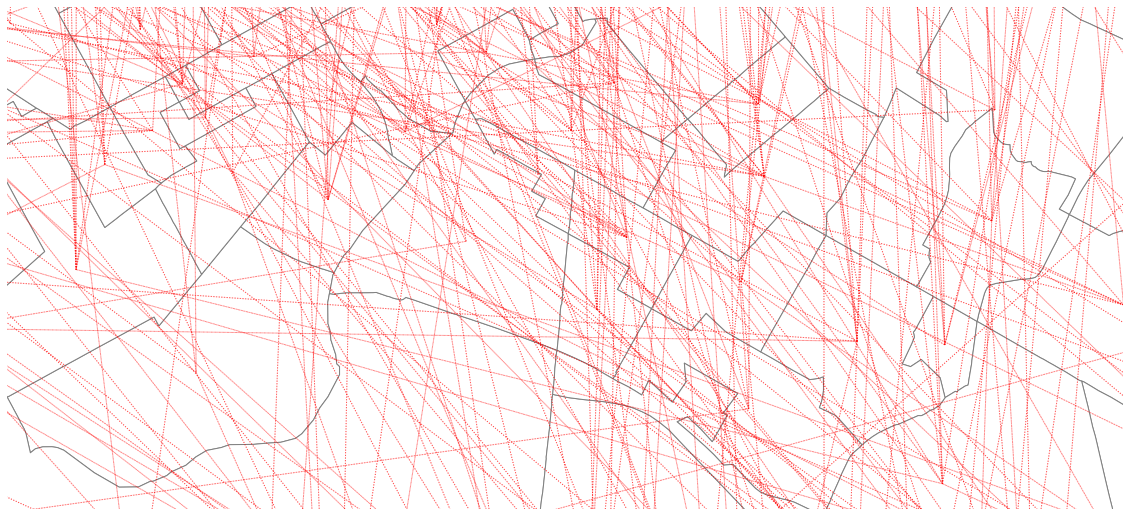

In [ ]:
ax = de_elecmap_ft[:-1].plot(edgecolor='grey', facecolor='w', figsize = (20,20))

queens_DE.plot(de_elecmap_ft, ax=ax, 
        edge_kws=dict(color='r', linestyle=':', alpha=0.5, linewidth=1),
        node_kws=dict(marker=''))


ax.set_axis_off()
plt.xlim((540640.585, 560640.585))

plt.ylim((-139818.275, -148818.275))


Figure 11: Zoomed in weights diagram using Queens weights. It is also easier to interpret the Queens weights with this diagram by looking at the number of connections coming frome each precinct. However, it is still difficult to compare Rook to Queens weights.

(-139818.275, -148818.275)

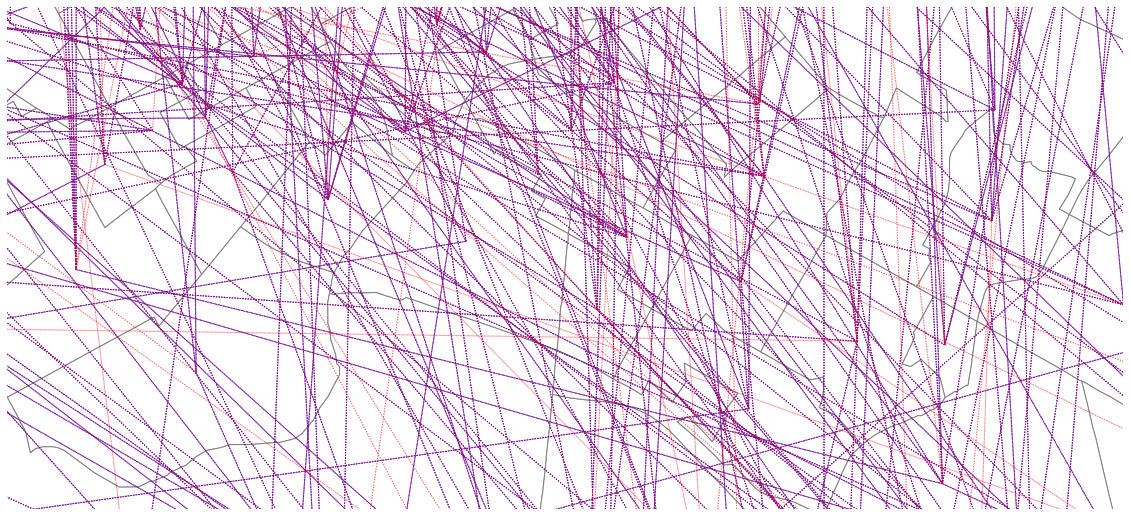

In [ ]:
ax = de_elecmap_ft[:-1].plot(edgecolor='grey', facecolor='w', figsize = (20,20))
rook_DE.plot(de_elecmap_ft, ax=ax, 
        edge_kws=dict(color='b', linestyle=':', linewidth=1),
        node_kws=dict(marker=''))
queens_DE.plot(de_elecmap_ft, ax=ax, 
        edge_kws=dict(color='r', linestyle=':', alpha=0.5, linewidth=1),
        node_kws=dict(marker=''))


ax.set_axis_off()
plt.xlim((540640.585, 560640.585))

plt.ylim((-139818.275, -148818.275))


Figure 12: By plotting Rook weights over Queens weights, the purple lines indicate that Rook and Queens weights are overlapping. There are also several red lines, areas where Queens connections are made but Rook connections are not. This shows how Queens weights create more connections than Rook weights.

Neighborhoods with more diagonally connected areas will have more connections with the Queens weights than the Rook weights.

# create the spatial lag metrics and calculate the global Moran's I

In [ ]:
import pysal.lib as ps

In [ ]:
voterturnoutlag = ps.weights.lag_spatial(queens_DE, vdata.voterturnout)
redvoteslag = ps.weights.lag_spatial(queens_DE, vdata.redvotes)
bluevoteslag = ps.weights.lag_spatial(queens_DE, vdata.bluevotes)

In [ ]:
# leave - just checking
np.where(vdata.voterturnout.isna())

(array([], dtype=int64),)

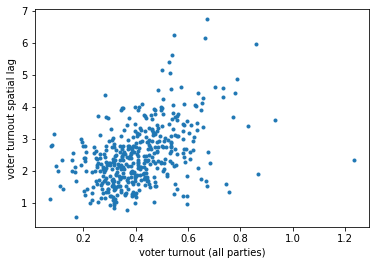

In [ ]:
# leave
plt.plot(vdata.voterturnout, voterturnoutlag, '.')
plt.xlabel("voter turnout (all parties)")
plt.ylabel("voter turnout spatial lag");

Figure 13: This plot shows lag or spatial autocorrelation for voter  turnout. This is how voter turnout correlates to itself over geographic space. The trend shows a postive correlation, meaning that areas with higher voter turnout tend to be around other areas with high voter turnout. The outlier of the precinct with higher than 1 in voter turnout is still seen all the way to the right, and it does not fit the trend of having neighbors with high turnout.

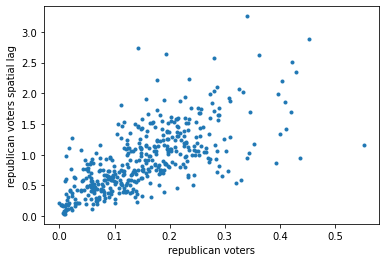

In [ ]:
plt.plot(vdata.redvotes, redvoteslag, '.')
plt.xlabel("republican voters")
plt.ylabel("republican voters spatial lag");

Figure 14: This plot shows spatial autocorrelation for republican voters in each precinct. The scatterplot also shows a positive correlation in which areas with high republican voters are sorrounded by other areas with high republican voters.

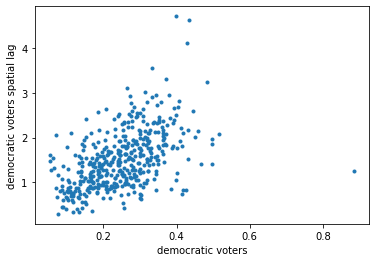

In [ ]:
plt.plot(vdata.bluevotes, bluevoteslag, '.')
plt.xlabel("democratic voters")
plt.ylabel("democratic voters spatial lag");

Figure 15: This plot shows spatial autocorrelation for democratic voters in each precinct. Again, a positive correlation is seen indicating that the amount of democratic voters in a precinct is similar in the sorrounding precincts. The outlier in voter turnout and democratic voters is seen all the way on the right. This point also doesn't fit the trend of having neighbors with high democratic votes.

## following the notebook example in class and the slides make a Moran'sI plot of each:
-all votes

-red votes

-blue votes

what do you notice?


In [ ]:
b,a = np.polyfit(vdata.voterturnout, voterturnoutlag, 1)
b,a                     

(2.8534424342281564, 1.3139655819624931)

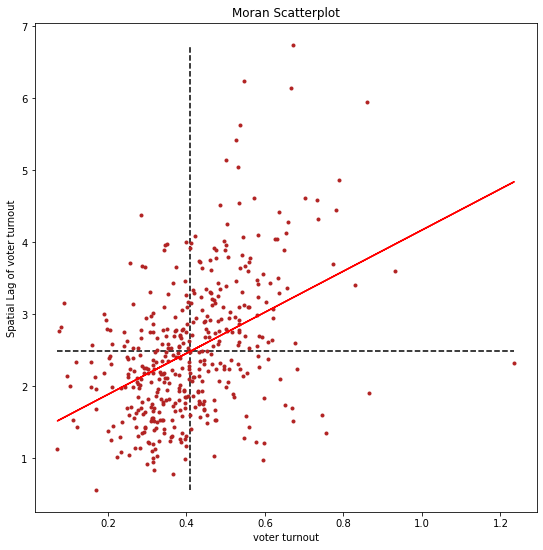

In [ ]:

f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(vdata.voterturnout, voterturnoutlag, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(vdata.voterturnout.mean(), voterturnoutlag.min(), voterturnoutlag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(voterturnoutlag.mean(), vdata.voterturnout.min(), vdata.voterturnout.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(vdata.voterturnout, a + b*vdata.voterturnout, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of voter turnout')
plt.xlabel('voter turnout');

Figure 16: A Moran's scatterplot for voter turnout. Values in the first quadrant indicate positive correlation, high voter turnouts being sorrounded by other high voter turnouts. The third quadrant shows values of low turnout that are sorrounded by other values of low turnout. The second and fourth quadrants show points that do not have a any spatial autocorrelation. The trend line shows the overall positive spatial autocorrelation for voter turnout.

In [ ]:
b,a = np.polyfit(vdata.redvotes, redvoteslag, 1)
b,a

(3.8237847993369702, 0.33410020691344655)

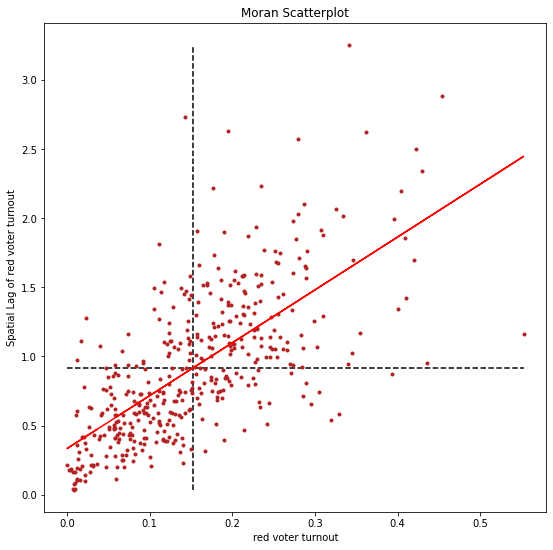

In [ ]:

f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(vdata.redvotes, redvoteslag, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(vdata.redvotes.mean(), redvoteslag.min(), redvoteslag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(redvoteslag.mean(), vdata.redvotes.min(), vdata.redvotes.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(vdata.redvotes, a + b*vdata.redvotes, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of red voter turnout')
plt.xlabel('red voter turnout');

Figure 16: Moran's scatterplot for republican voters. The first quadrant shows all the points of spatial autocorrelation in which high republican areas are surrounded by other high republican voting areas. The third quadrant shows the opposite, areas of low republican voters correlating with other areas of low republican voters over a geographic space. The second and fourth quadrants show the small amount of points that have no spatial autocorrelation, meaning that the amount of republican voters does not correlate with the sorrounding areas. This scatterplot appears to show the least amount of non-spatially autocorrelated points, indicating that republican voters has the strongest spatial autocorrelation.

In [ ]:
b,a = np.polyfit(vdata.bluevotes, bluevoteslag, 1)
b,a

(3.31906468228372, 0.6861534920777156)

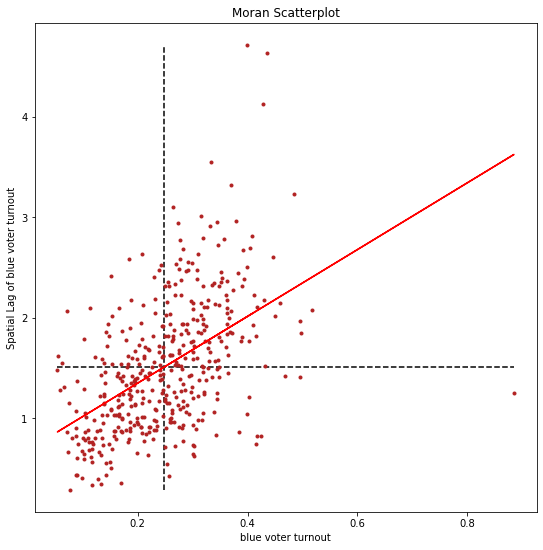

In [ ]:

f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(vdata.bluevotes, bluevoteslag, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(vdata.bluevotes.mean(), bluevoteslag.min(), bluevoteslag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(bluevoteslag.mean(), vdata.bluevotes.min(), vdata.bluevotes.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(vdata.bluevotes, a + b*vdata.bluevotes, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of blue voter turnout')
plt.xlabel('blue voter turnout');

Figure 17: Moran's scatterplot for democratic voters. The first quadrant shows high democratic voters correlating with high democratic voters in the sorrounding areas. The third quadrant shows low democratic voters correlating with other low democratic voters. Both of these quadrants show all the points that are spatially autocorrelated, while the second and fourth quadrant show all the precincts that are not spatially autocorrelated. The trend line again shows a strong positively correlated trend in the dataset.

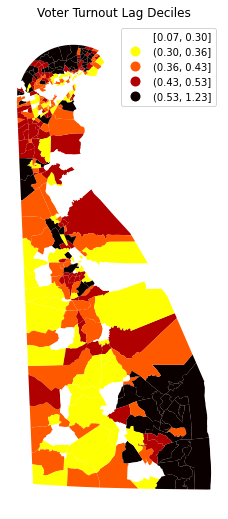

In [ ]:
f, ax = plt.subplots(figsize=(9, 9))
vdata.assign(cl=vdata.voterturnout).plot(column='cl', 
        k=5, cmap="hot_r", linewidth=0.1, ax=ax, 
         legend=True, scheme="quantiles")
ax.set_axis_off()
plt.title("Voter Turnout Lag Deciles");



Figure 18: This map shows the spatial autcorrelation of voter turnout mapped by precinct. The darker areas have a high spatial autocorrelation and are primaraly seen in northern New Castle County and Sussex County near the coast. Lighter areas show no spatial autocorrelation and are mostly seen in the larger precincts in Kent and Sussex county.

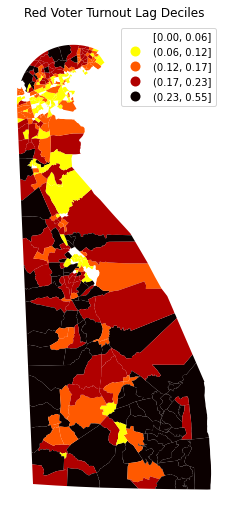

In [ ]:
f, ax = plt.subplots(figsize=(9, 9))
vdata.assign(cl=vdata.redvotes).plot(column='cl', 
        k=5, cmap="hot_r", linewidth=0.1, ax=ax, 
         legend=True, scheme="quantiles")
ax.set_axis_off()
plt.title("Red Voter Turnout Lag Deciles");

FIgure 19: Map of spatial autocorrelation for republican voters. The darker areas show high spatial autocorrelation, which is mostly seen in Sussex County. Low correlation is shown in the lighter colors and is more prominent in New Castle County. This indicates that there are large patches of precincts in the southern part of Delaware that have high republican voters.

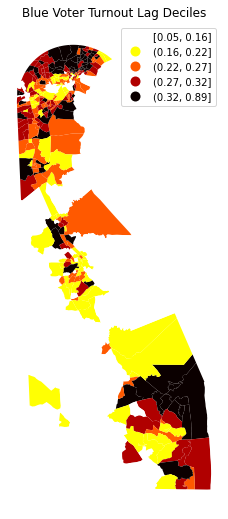

In [ ]:
f, ax = plt.subplots(figsize=(9, 9))
vdata.assign(cl=vdata.bluevotes).plot(column='cl', 
        k=5, cmap="hot_r", linewidth=0.1, ax=ax, 
         legend=True, scheme="quantiles")
ax.set_axis_off()
plt.title("Blue Voter Turnout Lag Deciles");

Figure 20: Map of democratic spatial autocorrelation in Delaware. Darker areas indicating high spatial autocorrelation, or areas of high democratic voters being sorrounded by other areas of high democratic voters is seen in the northern part of the state and the coast line in Sussex County. The majority of the rural areas in Kent and Sussex County show low spatial autocorrelation, indicating that areas of low democrats are sorrounded by other areas of low democrats.

# Follow the notebook to complete the *local* spatial analysis. 
# how can you interpret these results ? (we will talk about it in class on Monday too)

In [ ]:
from pysal.explore import esda

In [ ]:
mi1 = esda.Moran(voterturnoutlag, queens_DE)
mi2 = esda.Moran(redvoteslag, queens_DE)
mi3 = esda.Moran(bluevoteslag, queens_DE)


In [ ]:
for v, mi in zip(("all", "red", "blue"), (mi1, mi2, mi3)) :
  print("the global Moran's I for " + 
      "{} is {:.2f}\nwhich corresponds to a p-value of the spatial distribution being random {:.2g}".format(
   v, mi.I, mi.p_sim))

the global Moran's I for all is 0.29
which corresponds to a p-value of the spatial distribution being random 0.001
the global Moran's I for red is 0.67
which corresponds to a p-value of the spatial distribution being random 0.001
the global Moran's I for blue is 0.42
which corresponds to a p-value of the spatial distribution being random 0.001


what does this ^^^ statement actually mean in poorsman words? answer below


The global Moran's I gives a value of spatial autocorrelation, or how a variable correlates with itself over space for all the voting precincts in Delaware. Values above 0 indicate positive spatial autocorrelation, with higher values having a higher correlation. Negative values show a negative spatial autocorrelation with lower values having a stronger negative correlation.

The Global Moran's I value of .29 for voter turnout indicates a positive spatial autocorrelation with voter turnout. As voter turnout increases, voter turnout in neighboring areas increases.

The Global Moran's I value of .67 for red votes indicates an even higher positive correlation for republican voters. As republican voters go up, so to do republican voters in neighboring areas.

The Global Moran's I value of .42 for blue votes still indicates a positive correlation for democrat voters, however it is smaller than the correlation for republican voters. As democrat voters go up, so to do democrat voters in sorrounding areas. However, not as much as for republican voters.

The low p-values of .001 indicate a statistically significant autocorrelation with a low probablity of being due to random chance.

In [ ]:
LMo_red = esda.Moran_Local(vdata.redvotes.values, queens_DE, permutations=9999)


In [ ]:
LMo_blue = esda.Moran_Local(vdata.bluevotes.values, queens_DE, permutations=9999)


In [ ]:
sig = LMo_red.p_sim < 0.01
hotspotsR = LMo_red.q==1 * sig
coldspotsR = LMo_red.q==3 * sig
print ("Number of Hotspots:", hotspotsR.sum())
print ("Number of Coldspots:", coldspotsR.sum())

Number of Hotspots: 36
Number of Coldspots: 60


In [ ]:
sig = LMo_blue.p_sim < 0.01
hotspotsB = LMo_blue.q==1 * sig
coldspotsB = LMo_blue.q==3 * sig

print ("Number of Hotspots:", hotspotsB.sum())
print ("Number of Coldspots:", coldspotsB.sum())


Number of Hotspots: 35
Number of Coldspots: 50


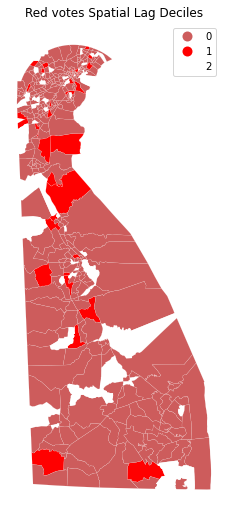

In [ ]:
from matplotlib import colors

hcmap = colors.ListedColormap(['Indianred','red','white'])
hotcold = hotspotsR*1 + coldspotsR*2

f, ax = plt.subplots(figsize=(9, 9))
de_elecmap_ft.assign(cl=hotcold).plot(column='cl', categorical=True, 
        k=3, cmap=hcmap, linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Red votes Spatial Lag Deciles");

Figure 21: Map of hot spots with local Morans I. Hotspots are value 1 shown in bright red, meaning high republican areas are present. These hotspots are seen scattered throughout the state. White areas with value 2 show cold spots in which areas of low republican voters are sorrounded other areas of low republican voters. There are 36 hotspots and 60 cold spots present in this republican dataset.

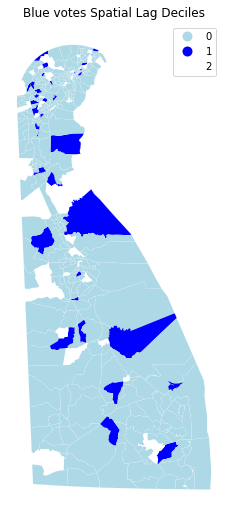

In [ ]:

hcmap = colors.ListedColormap(['lightblue','blue','white'])
hotcold = hotspotsB*1 + coldspotsB*2

f, ax = plt.subplots(figsize=(9, 9))
de_elecmap_ft.assign(cl=hotcold).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Blue votes Spatial Lag Deciles");

Figure 22: This map shows local Moran's I spatial autocorrelation for democratic voters in Delaware. Dark blue areas represent hot spots, mainly seen in New Castle County and represent high democratic voters. Cold spots are shown in white and represent areas of low democratic voters. There are 35 hot spots and 50 cold spots for democratic voters. This is one less hot spot when compared to republican voters, but 10 less cold spots, indicating less clusters of high democratic voters, but less clusters of low democratic voters when compared to republican voters.